In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from collections import namedtuple

In [2]:
n_agents = 2
history = 1
rewards = []
actions = []
states = []

with open('data0.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        row = [float(r) for r in row]
        rewards.append(row[:n_agents])
        actions.append(row[n_agents: 2*n_agents])
        states.append(row[2*n_agents:])

rewards = np.array(rewards)
actions = np.array(actions)
states = np.array(states)       

In [3]:
print(rewards.shape)
print(actions.shape)
print(states.shape)

(10000, 2)
(10000, 2)
(10000, 8)


### Get features in a scenario with history
We want to just get the features from the last time step. 

In [4]:
# state = namedtuple('state', ["sinr", "interference_caused", "n_success", "tx_powers",
#                              "interference_sensed", "buffer"])
n_features_per_agent = len(states[1]) // n_agents

did_transmit = []
n_success = []
interference_sensed = []
buffer = []


for s in states:
    #step_sinr = []
    step_n_success = []
    step_did_transmit = []
    step_interference_sensed = []
    step_buffer = []
    for i in range(n_agents):
        agent_features = s[i * n_features_per_agent: (i+1) * n_features_per_agent]
        
        step_did_transmit.append(agent_features[-4])
        step_n_success.append(agent_features[-3])
        step_interference_sensed.append(agent_features[-2])
        step_buffer.append(agent_features[-1])

    did_transmit.append(step_did_transmit)
    n_success.append(step_n_success)
    did_transmit.append(step_did_transmit)
    interference_sensed.append(step_interference_sensed)
    buffer.append(step_buffer)

    
did_transmit = np.array(did_transmit)
n_success = np.array(n_success)
interference_sensed = np.array(interference_sensed)
buffer = np.array(buffer)

In [5]:
print(actions)

[[-1. -1.]
 [ 4.  2.]
 [ 4.  2.]
 ...
 [ 2.  2.]
 [ 2.  2.]
 [ 2.  2.]]


In [6]:
print(sum(n_success[:, 0]))
print(np.sum(n_success, axis=0))
print(np.sum(rewards, axis=1))
unique, counts = np.unique(np.sum(rewards, axis=1), return_counts=True)
dict(zip(unique, counts))


3292.0
[3292. 3263.]
[0. 0. 1. ... 1. 1. 1.]


{-2.0: 600, 0.0: 2844, 1.0: 6556}

In [7]:
print(actions.flatten())
unique, counts = np.unique(actions.flatten(), return_counts=True)
dict(zip(unique, counts))

[-1. -1.  4. ...  2.  2.  2.]


{-1.0: 2, 0.0: 699, 1.0: 582, 2.0: 9749, 3.0: 1461, 4.0: 6232, 5.0: 1275}

### Convert to averages over a time window

In [8]:
history = 100

avgs = [[] for _ in range(n_agents)] # rewards
avg_buffer = np.zeros((states.shape[0], n_agents))
avg_throughput = np.zeros((states.shape[0], n_agents))

for i in range(history, len(rewards)):
    for j in range(n_agents):
        avgs[j].append(np.mean(rewards[:, j][i - history: i]))
        avg_buffer[i][j] = np.mean(buffer[:, j][i - history: i])
        avg_throughput[i][j] = np.mean(n_success[:, j][i - history: i])


reward_sum = [sum(rewards[i]) for i in range(len(rewards))]
avg_reward_sum = []
for i in range(history, len(rewards)):
    avg_reward_sum.append(np.mean(reward_sum[i - history: i]))

### Reward

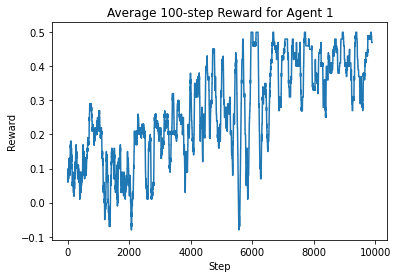

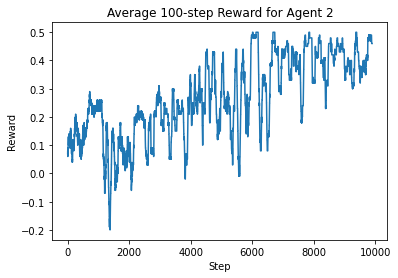

In [9]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avgs[i])
    plt.title("Average 100-step Reward for Agent " + str(i + 1))
    plt.xlabel("Step")
    plt.ylabel("Reward")
    
    #plt.show()
    #plt.savefig("reward" + str(i+1) + ".png")

### Actions

In [10]:
# Using np.unique is another way of doing this

agent_action_probs = [] # Time slice, agent_idx, action
possible_actions = sorted(list(set(actions.flatten())))
print("possible_actions", possible_actions)
steps = 100

for i in range(len(actions)//steps):
    action_slice = actions[i*steps: (i+1)*steps]
    agent_action_probs_this_time_slice = []
    for agent_index in range(n_agents):
        agent_actions = [0] * len(possible_actions)
        agent_action_slice = action_slice[:, agent_index]
        
        for i, action in enumerate(possible_actions):
            agent_actions[i] = np.count_nonzero(agent_action_slice == action)
             
        agent_action_probs_this_time_slice.append(np.array(agent_actions) / steps)
    
    agent_action_probs.append(agent_action_probs_this_time_slice)        

agent_action_probs = np.array(agent_action_probs)

possible_actions [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


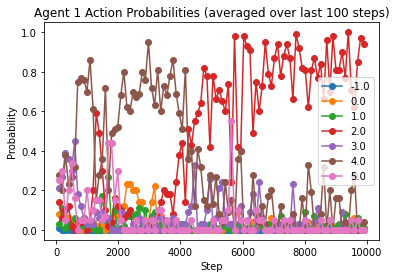

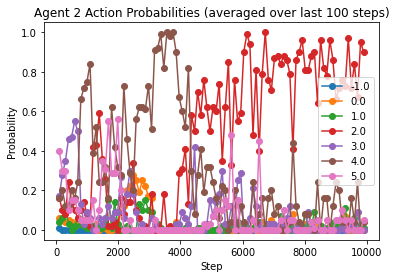

In [11]:
step_list = list(range(100, len(actions), 99))
labels = [str(a) for a in possible_actions]
#plt.plot(step_list, agent_action_probs[:, 0], label=['-1', '0', '1'])

for i in range(n_agents):
    fig = plt.figure()

    for j in range(len(possible_actions)):
        plt.plot(step_list, agent_action_probs[:, i, j], label=labels[j], marker='o')
    
    plt.legend(loc="right")
    plt.title("Agent " + str(i + 1) + " Action Probabilities (averaged over last 100 steps)")
    plt.xlabel("Step")
    plt.ylabel("Probability")
    #plt.savefig("Agent " + str(i + 1) + " Action Probabilities.png")

### Buffer

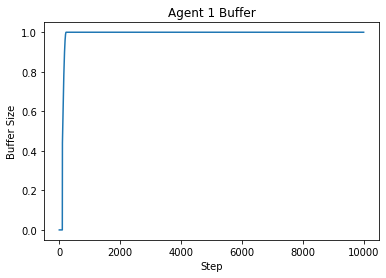

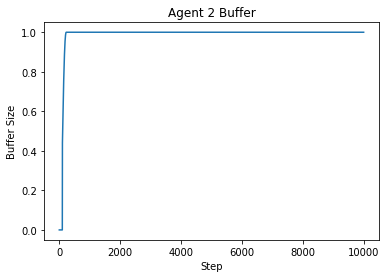

In [12]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_buffer[:, i])
    
    plt.title("Agent " + str(i + 1) + " Buffer")
    plt.xlabel("Step")
    plt.ylabel("Buffer Size")
    #plt.savefig("Agent " + str(i + 1) + " Buffer.png")

### Unsuccessful Transmissions

In [13]:
n_steps = 9999
n_unsuccess = np.zeros(n_agents)
n_unsuccess_time = np.zeros((n_agents, n_steps))
buffer_rate = 2

buffer_agent_step = buffer.T # Change shape for loop
for agent_idx in range(buffer_agent_step.shape[0]): # over agents
    for step_idx in range(buffer_agent_step.shape[1] - 1): # over steps
        current_buffer = buffer_agent_step[agent_idx, step_idx]
        next_buffer = buffer_agent_step[agent_idx, step_idx + 1]
        buffer_incremented = True if ((step_idx + 1) % 2 == 1) else False # on next step
        if buffer_incremented:
            if (current_buffer < next_buffer) & (current_buffer != 0):
                n_unsuccess[agent_idx] += 1
                n_unsuccess_time[agent_idx, step_idx] = 1
        else:
            if (current_buffer == next_buffer) & (current_buffer != 0):
                n_unsuccess[agent_idx] += 1
                n_unsuccess_time[agent_idx, step_idx] = 1

600.0
[0. 0. 0. ... 0. 0. 0.]
[0, 11.0, 9.0, 13.0, 9.0, 11.0, 9.0, 9.0, 3.0, 4.0, 2.0, 2.0, 5.0, 20.0, 15.0, 20.0, 11.0, 17.0, 6.0, 15.0, 10.0, 10.0, 13.0, 4.0, 1.0, 3.0, 3.0, 14.0, 3.0, 12.0, 1.0, 3.0, 5.0, 2.0, 7.0, 3.0, 5.0, 1.0, 1.0, 9.0, 11.0, 1.0, 7.0, 2.0, 5.0, 12.0, 0.0, 5.0, 4.0, 6.0, 10.0, 7.0, 9.0, 8.0, 12.0, 8.0, 4.0, 15.0, 1.0, 13.0, 9.0, 0.0, 1.0, 3.0, 12.0, 7.0, 14.0, 3.0, 0.0, 2.0, 6.0, 3.0, 1.0, 8.0, 2.0, 3.0, 4.0, 8.0, 0.0, 2.0, 1.0, 9.0, 2.0, 0.0, 8.0, 9.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 2.0, 4.0, 9.0, 1.0, 4.0, 6.0, 3.0, 1.0, 1.0]
[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500,

Text(0.5, 1.0, 'No of network unsuccesses averaged over 100 steps')

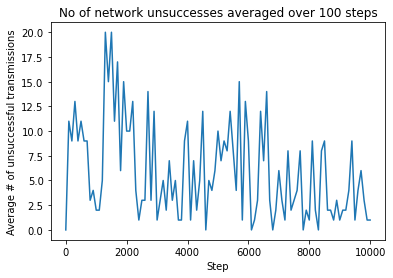

In [14]:
n_steps = 9999
n_unsuccess_test = [0]
n_unsuccess_time_test = [0]

reward_sum = np.sum(rewards, axis=1)
reward_sum_test = (np.where(reward_sum > 0, 0, reward_sum))
reward_sum_test = np.where(reward_sum_test == -2, 1, reward_sum_test)
print(np.sum(reward_sum_test))
for i in range(0, (n_steps+1), 100):
    n_unsuccess_test.append(np.sum(reward_sum_test[i:i+100]))
    n_unsuccess_time_test.append(i+100)
print(reward_sum_test)
print(n_unsuccess_test)
print(n_unsuccess_time_test)
plt.plot(n_unsuccess_time_test,n_unsuccess_test)
plt.xlabel('Step')
plt.ylabel('Average # of unsuccessful transmissions')
plt.title('No of network unsuccesses averaged over 100 steps')
# plt.savefig("network_unsuccesses.png")

In [15]:
print(n_unsuccess)

[4997. 4997.]


In [16]:
# buffer.shape
# print(buffer[:4, :], "\n")
# print(n_unsuccess_time.T[:4, :])

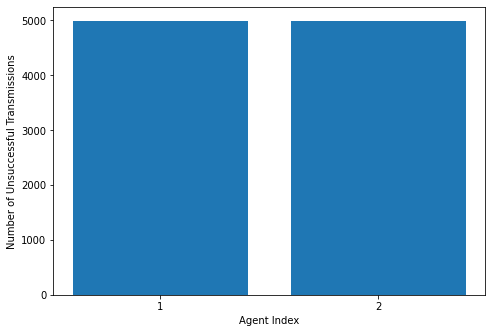

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(1, n_agents + 1), n_unsuccess)
ax.set_xticks(range(1, n_agents + 1))
ax.set_xlabel("Agent Index")
ax.set_ylabel("Number of Unsuccessful Transmissions")
#plt.savefig("Number of Unsuccessful Transmissions.png", bbox_inches='tight')

plt.show()

## Network  Performance 

### Average # of unsuccesses over all agents.

Text(0.5, 1.0, 'Sum of network unsuccesses averaged over 100 steps')

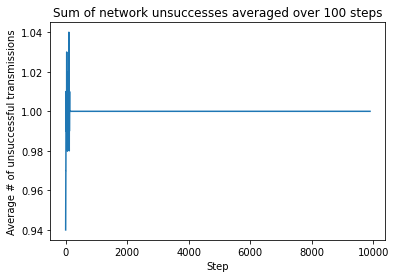

In [18]:
history = 100

network_unsuccess = np.sum(n_unsuccess_time, axis=0)
avg_network_unsuccess = []

for i in range(history, len(network_unsuccess)):
    avg_network_unsuccess.append(np.mean(network_unsuccess[i - history: i]))
    
plt.plot(avg_network_unsuccess)
plt.xlabel('Step')
plt.ylabel('Average # of unsuccessful transmissions')
plt.title('Sum of network unsuccesses averaged over 100 steps')
#plt.savefig("network_unsuccesses.png")

In [19]:
# Average number overall 
5000 / np.mean(n_unsuccess)

1.0006003602161297

###  Number of successes debug for this scenario
Required for previous runs of cdma19.

In [20]:
# Need to transform # of successes since there was a bug in GetObservations at the time.
# It has since been fixed, but the # of successes could only be incremeneted if the agent 
# choose agent=1.

# n_steps = 9999
# fixed_n_success = np.zeros((n_agents, n_steps))
# buffer_rate = 2

# buffer_agent_step = buffer.T # Change shape for loop

# for agent_idx in range(buffer_agent_step.shape[0]): # over agents
#     for step_idx in range(buffer_agent_step.shape[1] - 1): # over steps
#         current_buffer = buffer_agent_step[agent_idx, step_idx]
#         next_buffer = buffer_agent_step[agent_idx, step_idx + 1]
#         buffer_incremented = True if ((step_idx + 1) % 2 == 1) else False # on next step
#         if buffer_incremented:
#             if (current_buffer == next_buffer) & (current_buffer != 0):
#                 fixed_n_success[agent_idx, step_idx] = 1
#         else:
#             if (current_buffer > next_buffer) & (current_buffer != 0):
#                 fixed_n_success[agent_idx, step_idx] = 1

### Agent Throughput 

In packets per step, averaged for a 100 step window

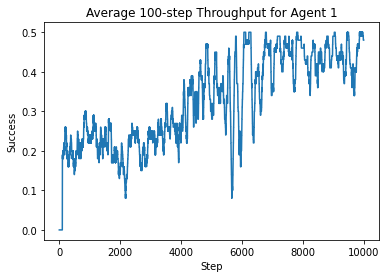

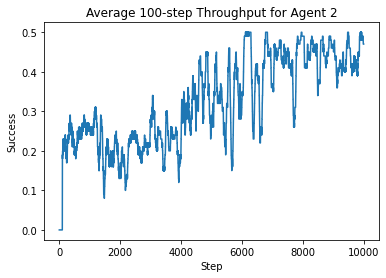

In [21]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_throughput[:, i])
    plt.title("Average 100-step Throughput for Agent " + str(i + 1))
    plt.xlabel("Step")
    plt.ylabel("Success")
    
    #plt.show()
    #plt.savefig("Success" + str(i+1) + ".png")

### Network throughput
Sum the throughput for all agents.

For the same history window as used in the throughput.

Text(0, 0.5, 'Avg Throughput (packet/step)')

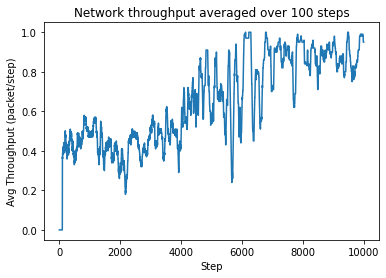

In [22]:
network_throuput = np.sum(avg_throughput, axis=1)

fig = plt.figure()
plt.plot(network_throuput)
plt.title("Network throughput averaged over 100 steps")
plt.xlabel("Step")
plt.ylabel("Avg Throughput (packet/step)")

### Fairness
Jain's fairness index

In [23]:
fairness = []

for step_idx in range(n_steps - history):
    numerator = sum(avg_throughput[step_idx, :])**2
    denominator = n_agents * sum(np.square(avg_throughput[step_idx, :]))
    fairness.append(numerator / denominator)

<ipython-input-23-510016152db9>:6: RuntimeWarning: invalid value encountered in double_scalars
  fairness.append(numerator / denominator)


In [24]:
avg_network_throuput = np.mean(network_throuput[-1000:-1])
print('Average Througput (Last 1000) = ', avg_network_throuput)
avg_fairness = np.mean(fairness[-1000:-1])
print('Average Fairness (Last 1000) = ', avg_fairness)

Average Througput (Last 1000) =  0.8785585585585586
Average Fairness (Last 1000) =  0.9980798412279321


Text(0, 0.5, 'Fairness')

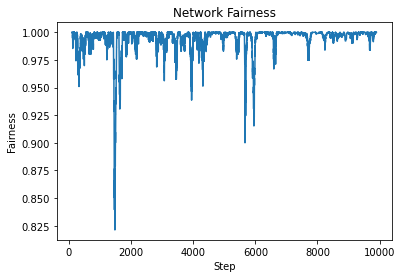

In [25]:
plt.plot(fairness)
plt.title("Network Fairness")
plt.xlabel("Step")
plt.ylabel("Fairness")
#plt.savefig("Fariness.png")

### Agent TX success probability

In [26]:
print(actions.shape)
did_transmit = np.zeros_like(actions)
for agent_idx in range(actions.shape[1]):
    for step_idx in range(actions.shape[0]):
        act = actions[step_idx, agent_idx]
        did_transmit[step_idx, agent_idx] = 0 if act == -1 else 1

(10000, 2)


In [27]:
tx_prob = np.zeros((states.shape[0] - 1, n_agents))

for i in range(len(rewards) - 1):
    for j in range(n_agents):
        effective_history = i if i < history else history # Avoid negative indices
        n_transmissions = sum(did_transmit[i-effective_history + 1:i+1, j])
        n_successes = sum(n_success[i-effective_history+1:i+1, j])
        if n_successes == 0:
            tx_prob[i][j] = 0
        else:
            tx_prob[i][j] = n_successes / n_transmissions 

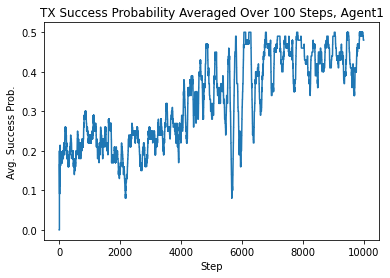

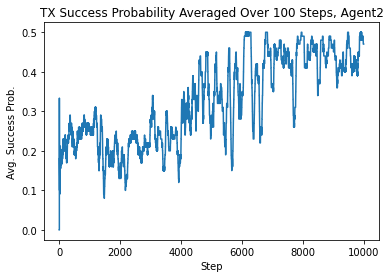

In [28]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(tx_prob[:, i])
    plt.title("TX Success Probability Averaged Over 100 Steps, Agent" + str(i + 1))
    plt.xlabel("Step")
    plt.ylabel("Avg. Success Prob.")
    #plt.savefig("TX_success_prob_Agent"+str(i+1)+".png")

### Network TX success probability

In [29]:
network_tx_prob = np.sum(tx_prob, axis=1) / n_agents

Text(0, 0.5, 'Success Prob.')

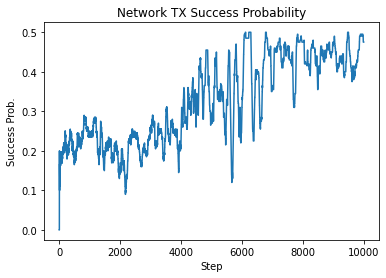

In [30]:
plt.plot(network_tx_prob)
plt.title("Network TX Success Probability")
plt.xlabel("Step")
plt.ylabel("Success Prob.")
#plt.savefig("Network_TX_success_prob")